In [2]:
import os
import json
import random
import re
import collections
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from transformers import GPT2LMHeadModel, GPT2Config, GPT2Tokenizer, pipeline
import timm
from torchinfo import summary
import warnings
import glob

In [3]:
# Set the device to GPU if available, otherwise use CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
random.seed(42)
warnings.filterwarnings("ignore")
# Define base path to the COCO 2017 dataset.
BASE_PATH = "/kaggle/input/coco-2017-dataset/coco2017"

Device: cuda


In [4]:
def preprocess_text(text):
    """
    Lowercases text, removes punctuation, extra whitespace, and
    appends start and end special tokens.
    """
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    text = text.strip()
    return "[start] " + text + " [end]"

def load_annotations(ann_path, img_folder):
    """
    Loads image annotations (captions) from a JSON file and maps each image path
    to its corresponding list of preprocessed captions.
    """
    img_to_cap = collections.defaultdict(list)
    with open(ann_path, "r") as f:
        data = json.load(f)["annotations"]
        for sample in data:
            # Format image filename with zero-padding (12 digits) and build full path.
            img_name = f'{sample["image_id"]:012d}.jpg'
            img_path = os.path.join(BASE_PATH, img_folder, img_name)
            caption = preprocess_text(sample["caption"])
            img_to_cap[img_path].append(caption)
    return img_to_cap

# Load training annotations (all training samples)
train_ann_path = os.path.join(BASE_PATH, "annotations", "captions_train2017.json")
img_to_cap_train = load_annotations(train_ann_path, "train2017")
train_images = list(img_to_cap_train.keys())
print("Total training images:", len(train_images))

# Load validation annotations from the separate validation dataset
val_ann_path = os.path.join(BASE_PATH, "annotations", "captions_val2017.json")
img_to_cap_val = load_annotations(val_ann_path, "val2017")
val_images = list(img_to_cap_val.keys())
print("Total validation images:", len(val_images))

df_train = pd.DataFrame(train_images, columns=["image"])
df_val = pd.DataFrame(val_images, columns=["image"])

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
special_tokens_dict = {"bos_token": "[start]", "eos_token": "[end]"}
tokenizer.add_special_tokens(special_tokens_dict)

MAX_LENGTH = 20  # Maximum caption length (including special tokens)

def tokenize_caption(caption):
    """
    Tokenizes and pads/truncates the caption to a fixed MAX_LENGTH.
    """
    encoding = tokenizer.encode_plus(
        caption,
        max_length=MAX_LENGTH,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    return encoding["input_ids"].squeeze(0)

Total training images: 118287
Total validation images: 5000


In [5]:
class CaptionDataset(Dataset):
    """
    A custom Dataset class that returns an image and a randomly chosen
    preprocessed caption (tokenized) for that image.
    """
    def __init__(self, image_paths, captions_mapping, transform=None):
        self.image_paths = image_paths
        self.captions_mapping = captions_mapping  # Mapping: image_path -> list of captions
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        # Randomly select one caption from the available captions for this image.
        captions_list = self.captions_mapping[img_path]
        caption = random.choice(captions_list)
        tokenized = tokenize_caption(caption)
        return image, tokenized

# Define transforms.
base_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
augment_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.ColorJitter(contrast=0.3),
    base_transform
])

BATCH_SIZE = 64
train_dataset = CaptionDataset(train_images, img_to_cap_train, transform=augment_transform)
val_dataset = CaptionDataset(val_images, img_to_cap_val, transform=base_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=4, pin_memory=True, persistent_workers=True)

In [6]:
# ViTEncoder: Extracts image features using a pre-trained Vision Transformer (ViT).
class ViTEncoder(nn.Module):
    def __init__(self, embed_size):
        super(ViTEncoder, self).__init__()
        # Load the pre-trained ViT model from timm.
        self.vit = timm.create_model("vit_base_patch16_224", pretrained=True)
        # Remove the classification head.
        self.vit.reset_classifier(0)
        # Freeze all ViT parameters to avoid updating during training.
        for param in self.vit.parameters():
            param.requires_grad = False
        # Linear layer to project ViT features to the desired embedding size.
        self.fc = nn.Linear(self.vit.num_features, embed_size)
        # Batch normalization for the projected features.
        self.bn = nn.BatchNorm1d(embed_size)
    
    def forward(self, images):
        features = self.vit(images)
        proj = self.fc(features)
        bn_out = self.bn(proj)
        return bn_out

# GPT2Decoder: A GPT-2 based decoder that generates text conditioned on image features.
class GPT2Decoder(nn.Module):
    def __init__(self, encoder_embed_size, prefix_length=10, gpt2_model_dir="gpt2", unfreeze_last=4):
        super().__init__()
        # Load GPT-2 configuration and adjust vocabulary size for our tokenizer.
        self.config = GPT2Config.from_pretrained(gpt2_model_dir)
        self.config.vocab_size = len(tokenizer)
        # Load GPT-2 model for language modeling.
        self.gpt2 = GPT2LMHeadModel.from_pretrained(
            gpt2_model_dir,
            config=self.config,
            ignore_mismatched_sizes=True
        )
        # Resize token embeddings to include our added special tokens.
        self.gpt2.resize_token_embeddings(len(tokenizer), mean_resizing=False)
        # Freeze GPT-2 parameters except for the last few layers.
        for param in self.gpt2.parameters():
            param.requires_grad = False
        total_layers = len(self.gpt2.transformer.h)
        # Unfreeze the last 'unfreeze_last' layers for fine-tuning.
        for i in range(total_layers - unfreeze_last, total_layers):
            for param in self.gpt2.transformer.h[i].parameters():
                param.requires_grad = True
        # Also unfreeze the final layer norm.
        for param in self.gpt2.transformer.ln_f.parameters():
            param.requires_grad = True

        self.prefix_length = prefix_length
        # Linear projection to map image features to a sequence of GPT-2 embeddings.
        self.embedding_proj = nn.Linear(encoder_embed_size, self.config.n_embd * prefix_length)
    
    def forward(self, image_features, input_ids, attention_mask=None):
        batch_size = image_features.size(0)
        # Project image features into a prefix sequence for GPT-2.
        prefix = self.embedding_proj(image_features)
        prefix = prefix.view(batch_size, self.prefix_length, self.config.n_embd)
        # Get GPT-2 embeddings for the input tokens.
        gpt2_inputs = self.gpt2.transformer.wte(input_ids)
        # Concatenate the image feature prefix with the token embeddings.
        inputs_embeds = torch.cat([prefix, gpt2_inputs], dim=1)
        # Create attention mask if none provided.
        if attention_mask is None:
            prefix_mask = torch.ones(batch_size, self.prefix_length, dtype=torch.long, device=inputs_embeds.device)
            attention_mask = torch.cat([prefix_mask, torch.ones_like(input_ids)], dim=1)
        # Forward pass through GPT-2 using the combined embeddings.
        outputs = self.gpt2(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        return outputs.logits

# Refinement: A simple MLP module that refines the logits output by the decoder.
class Refinement(nn.Module):
    def __init__(self, vocab_dim, hidden_dim=256):
        super().__init__()
        # Two-layer MLP with ReLU activation.
        self.mlp = nn.Sequential(
            nn.Linear(vocab_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, vocab_dim)
        )
    
    def forward(self, logits):
        # Compute refinement and add it back to the original logits.
        refined = self.mlp(logits)
        return logits + refined

# ImageCaptioningModel: Combines the encoder, decoder, and refinement modules.
class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder_embed_size, prefix_length, gpt2_model_dir="gpt2", augment=None):
        super().__init__()
        self.encoder = ViTEncoder(encoder_embed_size)
        self.decoder = GPT2Decoder(encoder_embed_size, prefix_length, gpt2_model_dir)
        self.refinement = Refinement(self.decoder.config.vocab_size)
        # Optional augmentation module for images.
        self.augment = augment

    def forward(self, images, input_ids, attention_mask=None, training=False):
        # Apply augmentation if in training mode.
        if training and self.augment is not None:
            images = self.augment(images)
        # Get image features from the encoder.
        image_features = self.encoder(images)
        # Generate logits from the decoder.
        logits = self.decoder(image_features, input_ids, attention_mask)
        # Refine logits using the refinement module.
        refined_logits = self.refinement(logits)
        return refined_logits

In [7]:
encoder_embed_size = 768
prefix_length = 20
model = ImageCaptioningModel(encoder_embed_size, prefix_length, gpt2_model_dir="gpt2", augment=None)
model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized because the shapes did not match:
- wte.weight: found shape torch.Size([50257, 768]) in the checkpoint and torch.Size([50259, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
dummy_images = torch.randn(1, 3, 224, 224).to(device)
dummy_input_ids = torch.randint(low=0, high=len(tokenizer), size=(1, MAX_LENGTH)).to(device)
# Get the model summary.
summary(model, input_data=(dummy_images, dummy_input_ids))

In [ ]:
print("Encoder (ViT):")
for name, module in model.encoder.named_children():
    print(f"  {name}: {module}")
    
print("\nDecoder (GPT-2 based):")
for name, module in model.decoder.named_children():
    print(f"  {name}: {module}")

print("\nRefinement:")
for name, module in model.refinement.named_children():
    print(f"  {name}: {module}")

In [8]:
def load_image_from_path(img_path):
    """
    Loads and preprocesses an image from disk using base_transform.
    """
    image = Image.open(img_path).convert("RGB")
    return base_transform(image)

def generate_caption_beam(img_path, beam_width=3, num_captions=3):
    """
    Generates captions for a given image using beam search.
    """
    model.eval()
    image = load_image_from_path(img_path)
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        img_embed = model.encoder(image)
    
    # Start generation with the [start] token.
    initial_tokens = tokenizer.encode("[start]", return_tensors="pt").to(device)
    beam = [("[start]", 0.0, initial_tokens)]
    completed = []
    
    # Generate tokens up to MAX_LENGTH.
    for _ in range(MAX_LENGTH - 1):
        new_beam = []
        for caption, score, tokens in beam:
            with torch.no_grad():
                # Get logits from the decoder without an explicit attention mask.
                logits = model.decoder(img_embed, tokens)
                # Refine logits.
                logits = model.refinement(logits)
            # Focus on the last token's logits.
            logits = logits[0, -1, :]
            log_probs = torch.log_softmax(logits, dim=-1)
            topk_log_probs, topk_indices = torch.topk(log_probs, beam_width)
            for log_prob, idx in zip(topk_log_probs, topk_indices):
                new_token = idx.unsqueeze(0).unsqueeze(0)
                new_tokens = torch.cat([tokens, new_token], dim=1)
                word = tokenizer.decode([idx.item()]).strip()
                new_caption = caption + " " + word
                new_score = score + log_prob.item()
                if word == "[end]":
                    completed.append((new_caption, new_score))
                else:
                    new_beam.append((new_caption, new_score, new_tokens))
        if not new_beam:
            break
        beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_width]
    
    # Choose the best completed captions or use the current beam.
    if completed:
        candidate_list = sorted(completed, key=lambda x: x[1], reverse=True)
    else:
        candidate_list = sorted(beam, key=lambda x: x[1], reverse=True)
    
    # Clean up the captions by removing special tokens.
    captions = [caption.replace("[start]", "").replace("[end]", "").strip() 
                for caption, score in candidate_list[:num_captions]]
    return captions

In [ ]:
checkpoint_path = "model_checkpoint.pth"
best_checkpoint_path = "best_model.pth"
start_epoch = 0
best_val_loss = float("inf")
train_losses, val_losses = [], []

# Load checkpoint if available.
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"], strict=False)
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"]
    best_val_loss = checkpoint["best_val_loss"]
    train_losses = checkpoint.get("train_losses", [])
    val_losses = checkpoint.get("val_losses", [])
    print(f"Loaded checkpoint from {checkpoint_path} at epoch {start_epoch}.")

EPOCHS = 200
patience = 2
patience_counter = 0

# Training loop with early stopping based on validation loss.
for epoch in range(start_epoch, EPOCHS):
    model.train()
    running_loss = 0.0
    for imgs, token_ids in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        imgs = imgs.to(device)
        token_ids = token_ids.to(device)
        input_ids = token_ids[:, :-1]  # Input tokens.
        target_ids = token_ids[:, 1:]  # Target tokens (shifted by one).
        
        optimizer.zero_grad()
        outputs = model(imgs, input_ids, training=True)
        logits = outputs[:, prefix_length:, :]  # Exclude the image prefix tokens.
        loss = criterion(logits.reshape(-1, logits.size(-1)), target_ids.reshape(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validation loop.
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for imgs, token_ids in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            imgs = imgs.to(device)
            token_ids = token_ids.to(device)
            input_ids = token_ids[:, :-1]
            target_ids = token_ids[:, 1:]
            outputs = model(imgs, input_ids, training=False)
            logits = outputs[:, prefix_length:, :]
            loss = criterion(logits.reshape(-1, logits.size(-1)), target_ids.reshape(-1))
            val_running += loss.item() * imgs.size(0)
    val_loss = val_running / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}: Training Loss {epoch_loss:.4f}, Validation Loss {val_loss:.4f}")
    
    # Save checkpoint.
    checkpoint = {
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "best_val_loss": best_val_loss,
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1} to {checkpoint_path}.")
    
    # Early stopping if no improvement.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(checkpoint, best_checkpoint_path)
        patience_counter = 0
        print(f"Best checkpoint updated at epoch {epoch+1} with Validation Loss: {val_loss:.4f}.")
    else:
        patience_counter += 1   
        print(f"No improvement for {patience_counter} epoch(s).")
     
    if patience_counter >= patience:
        print(f"No improvement for {patience} consecutive epochs; stopping early.") 
        break

# Load the best model weights.
if os.path.exists(best_checkpoint_path):
    best_checkpoint = torch.load(best_checkpoint_path, map_location=device)  
    model.load_state_dict(best_checkpoint["model_state_dict"])
    print(f"Restored best model weights from {best_checkpoint_path} at epoch {best_checkpoint['epoch']} with Validation Loss: {best_checkpoint['best_val_loss']:.4f}")

In [ ]:
if os.path.exists(best_checkpoint_path):
    best_checkpoint = torch.load(best_checkpoint_path, map_location=device)  
    model.load_state_dict(best_checkpoint["model_state_dict"])
    print(f"Restored best model weights from {best_checkpoint_path} at epoch {best_checkpoint['epoch']} with Validation Loss: {best_checkpoint['best_val_loss']:.4f}")

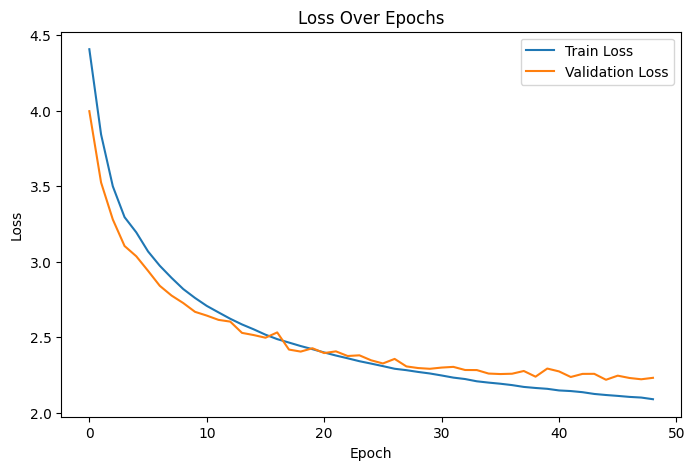

In [9]:
train_losses, val_losses = [], []
checkpoint_path = "model_checkpoint.pth"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    train_losses = checkpoint.get("train_losses", [])
    val_losses = checkpoint.get("val_losses", [])

# Plot training and validation loss over epochs.
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.show()

In [12]:
model = ImageCaptioningModel(encoder_embed_size, prefix_length, gpt2_model_dir="gpt2", augment=None)
model.load_state_dict(torch.load("model.pth", map_location=device))

model = model.to(device)

random.seed(None)
def test_model(model, image_paths, beam_width=3, num_captions=3):
    """
    Generates captions for a list of image paths using beam search.
    """
    model.eval()
    results = {}
    for img_path in image_paths:
        try:
            captions = generate_caption_beam(img_path, beam_width=beam_width, num_captions=num_captions)
            results[img_path] = captions
            print(f"Image: {img_path}\nCaptions:")
            for cap in captions:
                print(f"- {cap}")
            print("\n")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    return results

def show_captioned_image(img_path, captions):
    """
    Loads an image, reverses normalization, and displays it with generated captions.
    """
    try:
        image = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return
    # Reverse normalization: apply base_transform and then denormalize.
    image_transformed = base_transform(image)  
    image_np = image_transformed.cpu().numpy().transpose(1, 2, 0)
    image_np = image_np * 0.5 + 0.5  # Denormalize.
    image_np = image_np.clip(0, 1)    # Ensure valid pixel range.
    
    plt.figure(figsize=(8, 6))
    plt.imshow(image_np)
    # Display multiple captions on separate lines.
    plt.title("\n".join(captions), fontsize=10)
    plt.axis("off")
    plt.show()

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized because the shapes did not match:
- wte.weight: found shape torch.Size([50257, 768]) in the checkpoint and torch.Size([50259, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total test images: 40670
Image: /kaggle/input/coco-2017-dataset/coco2017/test2017/000000111929.jpg
Captions:
- a group of elephants are standing in a field
- a group of elephants are standing in the grass
- a group of elephants standing in a grass y field


Image: /kaggle/input/coco-2017-dataset/coco2017/test2017/000000331184.jpg
Captions:
- a sign that is sitting on the side of a hill
- a sign that is sitting on the side of a road
- a sign that is sitting on the side of a mountain


Image: /kaggle/input/coco-2017-dataset/coco2017/test2017/000000573863.jpg
Captions:
- a man sitting on a couch with a cell phone
- a group of people sitting around a table with a laptop
- a group of people sitting around a table with a cell phone


Image: /kaggle/input/coco-2017-dataset/coco2017/test2017/000000518114.jpg
Captions:
- a bowl of cereal sitting on a table
- a bowl of cereal sitting on top of a table
- a bowl of cereal sitting on top of a counter


Image: /kaggle/input/coco-2017-dataset/coco201

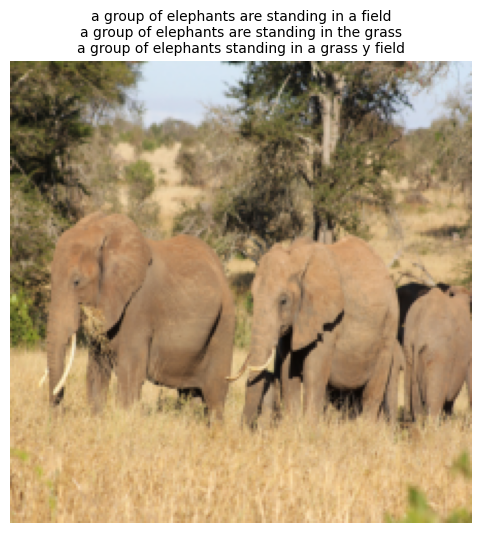

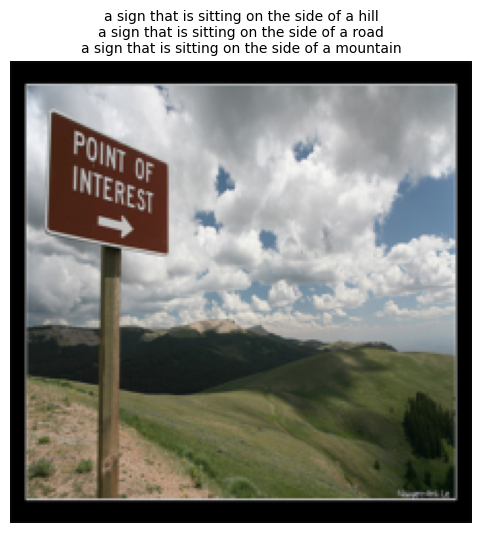

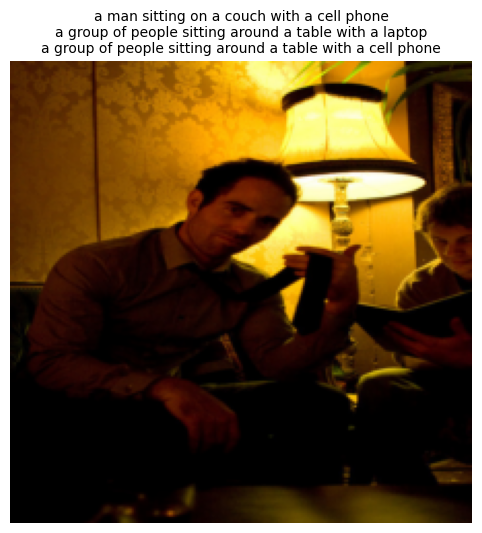

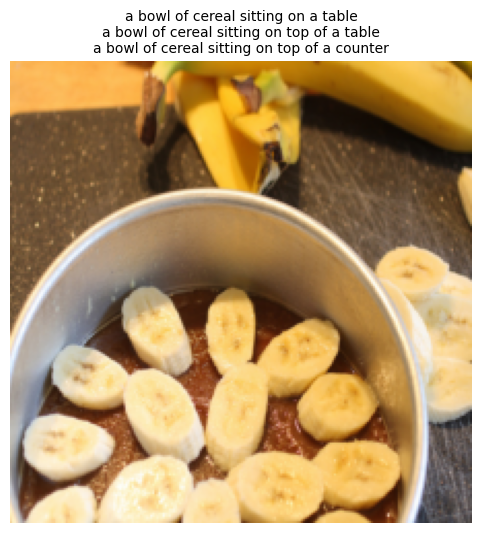

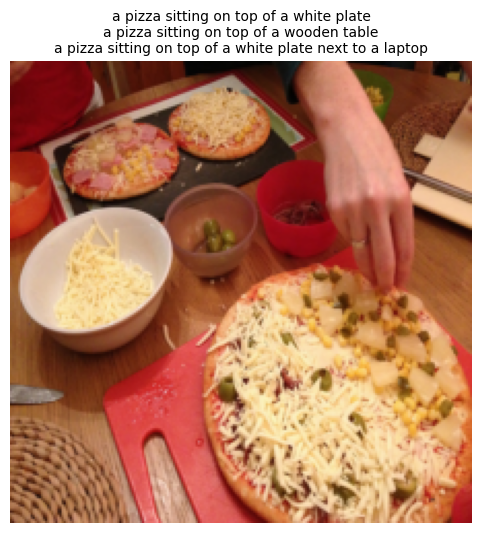

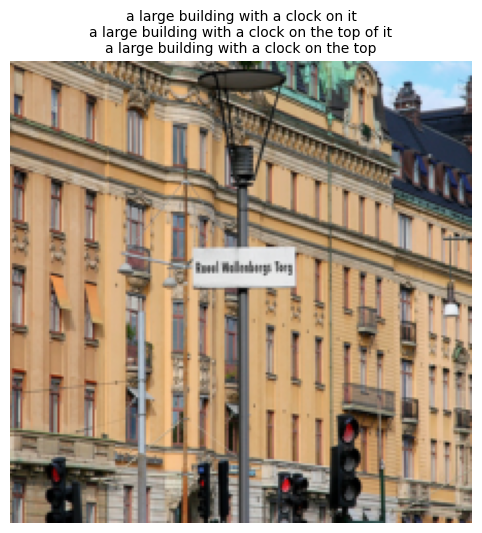

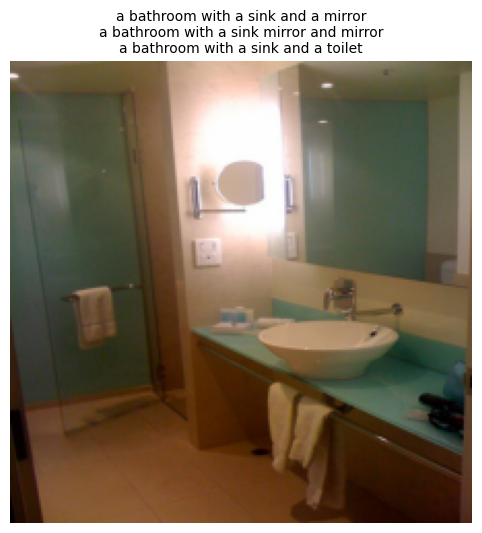

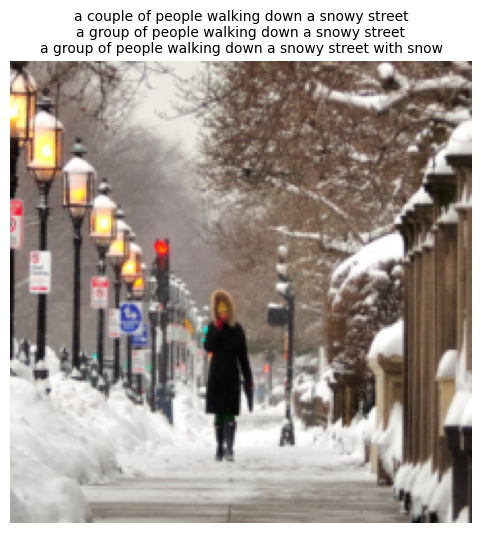

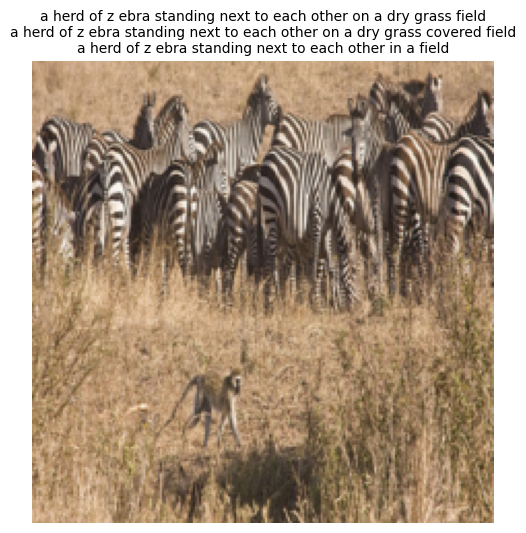

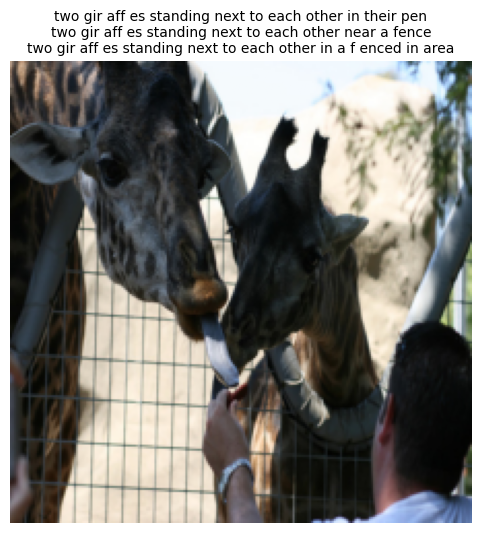

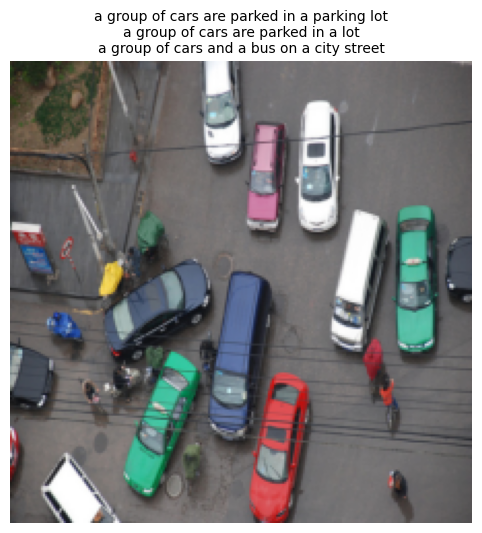

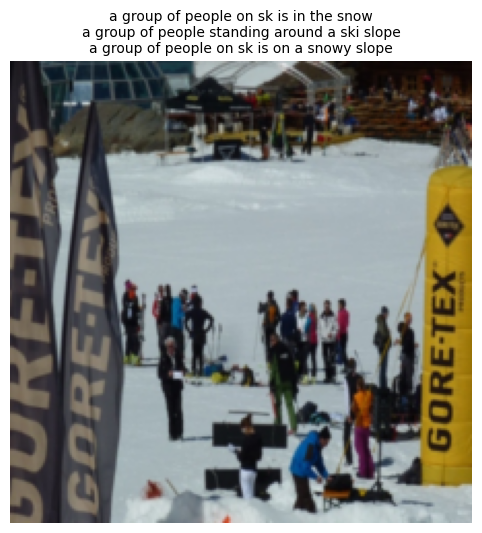

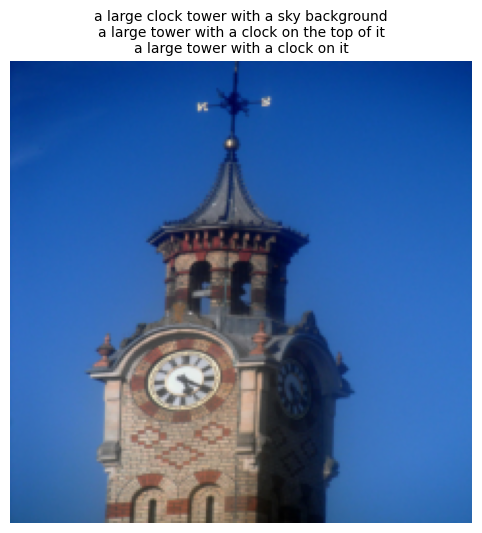

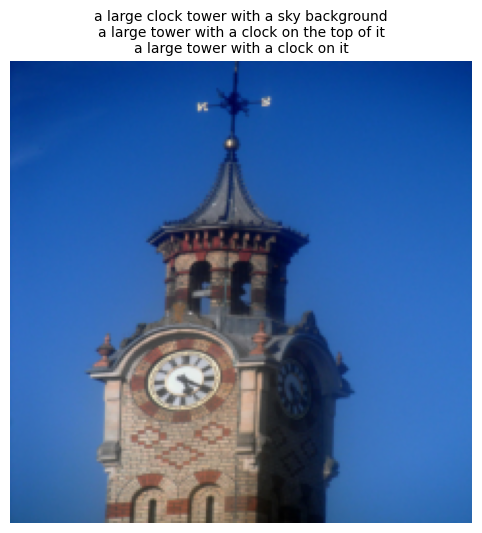

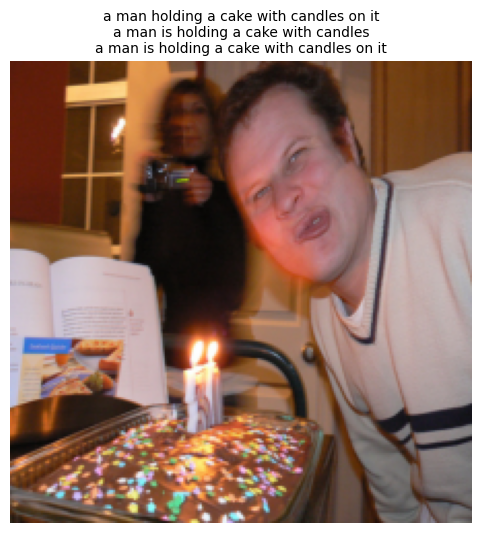

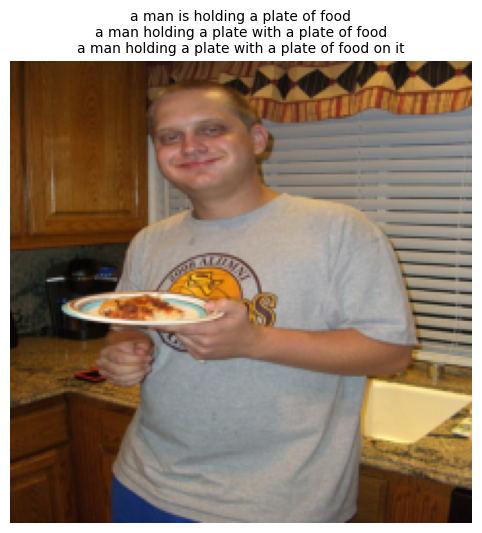

In [13]:
# Load test images from the test set.
test_image_folder = os.path.join(BASE_PATH, "test2017")
test_image_paths = glob.glob(os.path.join(test_image_folder, "*.jpg"))
print("Total test images:", len(test_image_paths))

# Optionally, use a subset for testing.
sample_test_images = random.sample(test_image_paths, 15)
results = test_model(model, sample_test_images, beam_width=3, num_captions=3)

# Display each image along with all generated captions.
for img_path, captions in results.items():
    show_captioned_image(img_path, captions)

In [ ]:
torch.save(model.state_dict(), 'model.pth')